# <b><u>False Positive Analysis and Cleaning<b><u>

This script offers a cleaning approach for falsly predicted crop pixels using a Random Forest Model which is trained on labeled training data.

### Load necessary packages

In [5]:
# Standard library imports
import math
import os
import random
import shutil
import tempfile
import gc
import json
import heapq
from collections import defaultdict
from itertools import product

# Third-party geospatial and data handling
import ee
import geemap
import geopandas as gpd
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.windows import Window
from osgeo import gdal, gdalconst, osr
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Geometry and spatial analysis
from shapely.geometry import Point
from scipy.spatial import cKDTree
from scipy.ndimage import distance_transform_edt, binary_dilation, label, binary_erosion, find_objects

# Machine learning and model evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Utilities and optimization
import joblib
from tqdm import tqdm
from scipy.stats import randint, uniform

# **Section 1: Reclassify Rasters and create Sampling Points**

#### Step 1: Reclassify Predicted Fractional Map to low frequency and high frequency crop field 

In [ ]:
# Input merged Raster
prediction_raster = "/home/airg/PSteinhilber/projects/angola/prediction/merged_fractional_map_new.tif"

In [ ]:
output_dir = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster"
os.makedirs(output_dir, exist_ok=True)  # Create directory if missing
output_path = os.path.join(output_dir, "crop_frequency_reclass_new.tif")

In [ ]:
# Open input raster
src_ds = gdal.Open(prediction_raster)
band = src_ds.GetRasterBand(1)
xsize = band.XSize
ysize = band.YSize

# Create output raster with same dimensions and projection
driver = gdal.GetDriverByName('GTiff')
dst_ds = driver.Create(
    output_path, xsize, ysize, 1, gdal.GDT_Byte,
    options=['COMPRESS=LZW', 'BIGTIFF=YES']
)
dst_ds.SetProjection(src_ds.GetProjection())
dst_ds.SetGeoTransform(src_ds.GetGeoTransform())
out_band = dst_ds.GetRasterBand(1)
out_band.SetNoDataValue(0)

# Optimize block size based on raster structure
block_sizes = band.GetBlockSize()
x_block_size = block_sizes[0]
y_block_size = block_sizes[1]

# Process raster in blocks
for y in range(0, ysize, y_block_size):
    if y + y_block_size < ysize:
        rows = y_block_size
    else:
        rows = ysize - y
        
    for x in range(0, xsize, x_block_size):
        if x + x_block_size < xsize:
            cols = x_block_size
        else:
            cols = xsize - x

        # Read block
        data = band.ReadAsArray(x, y, cols, rows)
        
        # Reclassify using vectorized operations
        reclassified = np.full(data.shape, 0, dtype=np.uint8)  # Initialize with NoData
        mask_low = (data > 0) & (data <= 50)
        mask_high = data > 50
        reclassified[mask_low] = 1
        reclassified[mask_high] = 2
        
        # Write block
        out_band.WriteArray(reclassified, x, y)

# Finalize output
dst_ds.FlushCache()
dst_ds = None
src_ds = None

### Step 2: Create Crop Mask using 4 Crop Layers (ESRI Cropland, UMD GLAD, ESA, GFSAD)

In [ ]:
# Initialize Earth Engine
ee.Initialize()

# Load Angola tiles asset
angola_tiles = ee.FeatureCollection('projects/angola-thesis/assets/angola_tiles_dissolve')

# ESRI 2023 Cropland
esri_2023 = (ee.ImageCollection("projects/sat-io/open-datasets/landcover/ESRI_Global-LULC_10m_TS")
    .filterDate('2023-01-01', '2023-12-31')
    .mosaic()
    .clip(angola_tiles)
    .eq(5)
    .rename('esri_crop')
    .toByte())

# UMD GLAD 2019 Cropland
umd_cropland = (ee.ImageCollection("users/potapovpeter/Global_cropland_2019")
    .filterBounds(angola_tiles)
    .mosaic()
    .clip(angola_tiles)
    .eq(1)
    .rename('umd_crop')
    .toByte())

# ESA WorldCover 2021 Cropland
esa_cropland = (ee.ImageCollection("ESA/WorldCover/v200")
    .first()
    .clip(angola_tiles)
    .eq(40)
    .rename('esa_crop')
    .toByte())

# GFSAD30 2015 Cropland
gfsad_cropland = (ee.ImageCollection("projects/sat-io/open-datasets/GFSAD/GCEP30")
    .mosaic()
    .clip(angola_tiles)
    .eq(2)
    .rename('gfsad_crop')
    .toByte())

# Invert all cropland masks
esri_non_crop = esri_2023.Not().rename('esri_non')
umd_non_crop = umd_cropland.Not().rename('umd_non')
esa_non_crop = esa_cropland.Not().rename('esa_non')
gfsad_non_crop = gfsad_cropland.Not().rename('gfsad_non')

# Combine inverted masks
combined_non = (esri_non_crop
                .add(umd_non_crop)
                .add(esa_non_crop)
                .add(gfsad_non_crop)
                .clip(angola_tiles)
                .rename('non_crop_agreement'))

# Rescale combined layer (0-1, then 0-100)
rescaled = (combined_non
            .divide(4)
            .rename('rescaled_agreement')
            .multiply(100)
            .toInt8())

# Define Angola bounding box and split
minLon = 11.65452499950938
maxLon = 24.06347641355087
minLat = -18.06447613052441
maxLat = -4.355525027108801
midLon = (minLon + maxLon) / 2

west = ee.Geometry.Rectangle([minLon, minLat, midLon, maxLat])
east = ee.Geometry.Rectangle([midLon, minLat, maxLon, maxLat])

# Print area for verification
west_area = west.area().getInfo() / 1e6
east_area = east.area().getInfo() / 1e6
print(f"West area (km²): {west_area:.2f}")
print(f"East area (km²): {east_area:.2f}")

# Visualization
#Map = geemap.Map(center=[-12, 17], zoom=6)
#Map.addLayer(rescaled, {'min': 0, 'max': 100, 'palette': ['#00FF00', '#FF0000']}, 'Rescaled Agreement 0-1')
#Map.addLayer(west, {}, 'West Part')
#Map.addLayer(east, {}, 'East Part')
#Map

# Export to Google Drive
task_west = ee.batch.Export.image.toDrive(
    image=rescaled.clip(west),
    description='Angola_West',
    folder='Thesis',
    fileNamePrefix='angola_west',
    region=west,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF',
    formatOptions={'cloudOptimized': True}
)
task_east = ee.batch.Export.image.toDrive(
    image=rescaled.clip(east),
    description='Angola_East',
    folder='Thesis',
    fileNamePrefix='angola_east',
    region=east,
    scale=10,
    maxPixels=1e13,
    fileFormat='GeoTIFF',
    formatOptions={'cloudOptimized': True}
)
# Start export tasks
# task_west.start()
# task_east.start()
print("Exports started. Check your GEE Tasks tab.")

### Step 3: Reclassify Land Cover Crop Raster to 3 classes: 0 (all agree non-crop), 1 (1-2 agree it's crop), 2 (3-4 agree it's crop)

In [ ]:
input_path = r"C:\Users\phili\Thesis\tmp\no_crop_mask\non_crop_mask_final.tif"
output_dir = r"C:\Users\phili\Thesis\tmp\false_positive_analysis\FP_Raster_output"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "landcover_crop_reclass.tif")

In [ ]:
with rasterio.open(input_path) as src:
    profile = src.profile.copy()
    profile.update(
        dtype='uint8',
        nodata=255,
        compress='lzw'
    )
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        # Process raster in 512x512 blocks
        for ji, window in src.block_windows(1):
            data = src.read(1, window=window)
            
            # Initialize output with NoData (255)
            reclassified = np.full_like(data, 255, dtype='uint8')
            
            # Exact value reclassification
            reclassified[data == 100] = 0    # Class 0
            reclassified[data == 75] = 1     # Class 1
            reclassified[data == 50] = 1     # Class 1
            reclassified[data == 25] = 2     # Class 2
            reclassified[data == 0] = 2      # Class 2
            
            dst.write(reclassified, window=window, indexes=1)

### Step 4: Intersect both Maps

In [ ]:
# Input paths
crop_freq_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/crop_frequency_reclass.tif"
lc_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/landcover_crop_reclass.tif"
output_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/intersect_fractional_lc.tif"

In [ ]:
# Configure GDAL for big datasets
gdal.SetConfigOption('GDAL_DISABLE_READDIR_ON_OPEN', 'YES')
gdal.SetConfigOption('CHECK_DISK_FREE_SPACE', 'NO')
gdal.SetConfigOption('GDAL_NUM_THREADS', 'ALL_CPUS')

# Open datasets
crop_ds = gdal.OpenEx(crop_freq_path, gdalconst.GA_ReadOnly)
lc_ds = gdal.OpenEx(lc_path, gdalconst.GA_ReadOnly)

# Get crop raster parameters
crop_gt = crop_ds.GetGeoTransform()
crop_proj = crop_ds.GetProjection()
cols = crop_ds.RasterXSize
rows = crop_ds.RasterYSize

# Create output with compression
driver = gdal.GetDriverByName('GTiff')
output_ds = driver.Create(
    output_path, cols, rows, 1, gdalconst.GDT_Byte,
    options=['COMPRESS=LZW', 'PREDICTOR=2', 'TILED=YES', 'BIGTIFF=YES', 'BLOCKXSIZE=256', 'BLOCKYSIZE=256']
)
output_ds.SetGeoTransform(crop_gt)
output_ds.SetProjection(crop_proj)
output_band = output_ds.GetRasterBand(1)
output_band.SetNoDataValue(0)

# Process in blocks with exact dimension matching
block_size = 1024  # Keep this as-is
total_blocks = ((rows + block_size - 1) // block_size) * ((cols + block_size - 1) // block_size)

with tqdm(total=total_blocks, desc="Processing", unit="block") as pbar:
    for y_offset in range(0, rows, block_size):
        y_height = min(block_size, rows - y_offset)
        
        for x_offset in range(0, cols, block_size):
            x_width = min(block_size, cols - x_offset)
            
            # Read crop frequency block
            crop_block = crop_ds.GetRasterBand(1).ReadAsArray(x_offset, y_offset, x_width, y_height)
            
            # Calculate exact bounds for this block
            x_min = crop_gt[0] + x_offset * crop_gt[1]
            y_max = crop_gt[3] + y_offset * crop_gt[5]
            x_max = x_min + x_width * crop_gt[1]
            y_min = y_max + y_height * crop_gt[5]
            
            # Warp LC data with EXPLICIT output dimensions
            lc_block = gdal.Warp('', lc_path,
                format='MEM',
                outputBounds=(x_min, y_min, x_max, y_max),
                xRes=crop_gt[1],
                yRes=abs(crop_gt[5]),
                width=x_width,  # Force exact dimension match
                height=y_height,
                resampleAlg=gdalconst.GRA_NearestNeighbour,
                outputType=gdalconst.GDT_Byte
            ).ReadAsArray()
            
            # Verify block shapes match
            if crop_block.shape != lc_block.shape:
                raise ValueError(f"Block shape mismatch at ({x_offset},{y_offset}): {crop_block.shape} vs {lc_block.shape}")
            
            # Calculate output classes
            output_data = np.zeros_like(crop_block, dtype=np.uint8)
            
            # Class mapping with explicit casting
            output_data = output_data.astype(np.uint8)
            output_data[(crop_block == 1) & (lc_block == 0)] = 1
            output_data[(crop_block == 1) & (lc_block == 1)] = 2
            output_data[(crop_block == 1) & (lc_block == 2)] = 3
            output_data[(crop_block == 2) & (lc_block == 0)] = 4
            output_data[(crop_block == 2) & (lc_block == 1)] = 5
            output_data[(crop_block == 2) & (lc_block == 2)] = 6
            
            # Write output with exact window
            output_band.WriteArray(output_data, xoff=x_offset, yoff=y_offset)
            pbar.update(1)

# Cleanup
output_ds = None
crop_ds = None
lc_ds = None

print(f"✅ Success! Output created at: {output_path}")

### Step 5: Sample Points within each class

In [13]:
raster_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/intersect_fractional_lc.tif"
output_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/sampling_points.gpkg"

In [ ]:
def count_classes_blocked(raster_path):
    """Count pixels per class with progress tracking"""
    ds = gdal.Open(raster_path, gdal.GA_ReadOnly)
    band = ds.GetRasterBand(1)
    nodata = band.GetNoDataValue()
    xsize, ysize = band.XSize, band.YSize
    block_x, block_y = band.GetBlockSize()
    
    counts = {}
    total_blocks = ((ysize + block_y - 1) // block_y) * ((xsize + block_x - 1) // block_x)
    
    with tqdm(total=total_blocks, desc="Counting classes", unit="block") as pbar:
        for y in range(0, ysize, block_y):
            y_height = min(block_y, ysize - y)
            for x in range(0, xsize, block_x):
                x_width = min(block_x, xsize - x)
                data = band.ReadAsArray(x, y, x_width, y_height)
                
                if nodata is not None:
                    data = data[data != nodata]
                
                unique, counts_chunk = np.unique(data, return_counts=True)
                for val, cnt in zip(unique, counts_chunk):
                    if val == 0:  # Skip NoData
                        continue
                    counts[val] = counts.get(val, 0) + int(cnt)
                
                pbar.update(1)
    
    ds = None
    return counts

In [ ]:
# Count classes
class_counts = count_classes_blocked(intersect_raster)
print("Pixel counts per class:", class_counts)

In [ ]:
# Use pre-calculated pixel counts
pixel_counts = {3: 431784025, 1: 15857486835, 4: 6093596578, 
                5: 3622280348, 2: 3342416411, 6: 1171686069}
total_pixels = sum(pixel_counts.values())

# Calculate proportional samples
samples_per_class = {
    cls: max(1, ceil((count / total_pixels) * 300)) 
    for cls, count in pixel_counts.items()
}

In [ ]:
def calculate_samples(pixel_counts, total_samples=300):
    total = sum(pixel_counts.values())
    samples = {
        cls: max(1, int(round((count / total) * total_samples)))
        for cls, count in pixel_counts.items()
    }
    # Adjust to exact total
    current_total = sum(samples.values())
    if current_total != total_samples:
        adjust_cls = max(samples, key=lambda k: samples[k])
        samples[adjust_cls] += (total_samples - current_total)
    return samples

In [ ]:
def random_pixel_sampling(raster_path, samples_per_class, max_attempts=1000000, min_distance_deg=0.001):
    with rasterio.open(raster_path) as src:
        height, width = src.height, src.width
        classes_needed = samples_per_class.copy()
        found_points = defaultdict(list)
        found_coords = []

        total_needed = sum(classes_needed.values())
        attempts = 0

        # For progress bar
        pbar = tqdm(total=total_needed, desc="Random sampling", unit="pt")

        while sum(classes_needed.values()) > 0 and attempts < max_attempts:
            # Random pixel
            row = random.randint(0, height - 1)
            col = random.randint(0, width - 1)
            val = src.read(1, window=rasterio.windows.Window(col, row, 1, 1))[0, 0]

            # Only sample if this class still needs points
            if val in classes_needed and classes_needed[val] > 0:
                # Convert to lon/lat
                lon, lat = src.xy(row, col)
                pt = Point(lon, lat)

                # Check minimum distance constraint
                too_close = False
                for other_pt in found_coords:
                    if pt.distance(other_pt) < min_distance_deg:
                        too_close = True
                        break
                if too_close:
                    attempts += 1
                    continue

                found_points[val].append(pt)
                found_coords.append(pt)
                classes_needed[val] -= 1
                pbar.update(1)
            attempts += 1

        pbar.close()

        # Flatten to GeoDataFrame
        data = []
        for cls, pts in found_points.items():
            for pt in pts:
                data.append({'class': cls, 'geometry': pt})
        gdf = gpd.GeoDataFrame(data, crs='EPSG:4326')

        if sum(classes_needed.values()) > 0:
            print(f"Warning: Could not find all samples. Missing: {classes_needed}")

        return gdf

In [ ]:
def main():
    samples = calculate_samples(pixel_counts)
    print("Samples per class:", samples)
    gdf = random_pixel_sampling(raster_path, samples, min_distance_deg=0.001)  # ~100m at equator
    gdf.to_file(output_path, driver="GPKG")
    print(f"Saved {len(gdf)} points to {output_path}")

if __name__ == "__main__":
    main()

#### Step 5.1: Add extra sampling points to make sample more balanced (Optional)

In [29]:
def add_class6_samples():
    # Path configurations
    existing_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/sampling_points.gpkg"
    output_path_extended = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/sampling_points_extended.gpkg"
    
    # Read existing points
    existing_gdf = gpd.read_file(existing_path)
    
    # Generate 100 new samples for class 6 with distance checks against existing points
    samples = {6: 100}
    
    # Modified sampling function with existing coordinates check
    def class6_sampling(raster_path, samples_per_class, existing_coords, min_distance_deg=0.001):
        with rasterio.open(raster_path) as src:
            height, width = src.height, src.width
            classes_needed = samples_per_class.copy()
            found_points = []
            found_coords = [pt for pt in existing_coords]  # Start with existing points

            pbar = tqdm(total=samples_per_class[6], desc="Sampling class 6", unit="pt")
            attempts = 0
            
            while classes_needed[6] > 0 and attempts < 1000000:
                row = random.randint(0, height - 1)
                col = random.randint(0, width - 1)
                val = src.read(1, window=rasterio.windows.Window(col, row, 1, 1))[0, 0]

                if val == 6:
                    lon, lat = src.xy(row, col)
                    pt = Point(lon, lat)
                    
                    # Check against all existing and new points
                    too_close = any(pt.distance(other) < min_distance_deg for other in found_coords)
                    
                    if not too_close:
                        found_points.append({'class': 6, 'geometry': pt})
                        found_coords.append(pt)
                        classes_needed[6] -= 1
                        pbar.update(1)
                        
                    attempts += 1

            pbar.close()
            return gpd.GeoDataFrame(found_points, crs='EPSG:4326')

    # Get existing coordinates for distance checks
    existing_coords = existing_gdf.geometry.tolist()
    
    # Generate new points
    new_gdf = class6_sampling(raster_path, samples, existing_coords)
    
    # Combine with existing data
    combined_gdf = gpd.pd.concat([existing_gdf, new_gdf], ignore_index=True)
    
    # Save extended dataset
    combined_gdf.to_file(output_path_extended, driver="GPKG")
    print(f"Successfully created extended dataset with {len(combined_gdf)} points")

# Execute the addition
add_class6_samples()

Sampling class 6: 100%|███████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60pt/s]


Successfully created extended dataset with 400 points


#### Step 5.2: Add 100 extra points based on prediction raster (After creating RF Model Prediction) (Optional)

In [16]:
# ========= CONFIGURATION =========
rf_raster = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/RF_Model/model_output/rf_full_prediction.tif"
EXISTING_POINTS_PATH = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/sampling_points_labeled_extended.shp"
OUTPUT_PATH = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/sampling_points_ext_rf.shp"
NUM_POINTS = 100  # Total new points
MIN_DISTANCE = 50  # Minimum distance to nearest existing point (meters)
DENSITY_RADIUS = 70000  # Check density within this radius (meters)
MAX_DENSITY = 3  # Max allowed existing points in DENSITY_RADIUS
# =================================

# Load main raster metadata (no array)
ds = gdal.Open(rf_raster)
band = ds.GetRasterBand(1)
transform = ds.GetGeoTransform()
nodata = band.GetNoDataValue()
x_size = ds.RasterXSize
y_size = ds.RasterYSize

# Get raster CRS
srs = osr.SpatialReference()
srs.ImportFromWkt(ds.GetProjection())
raster_crs = srs.ExportToProj4()

# Load existing points and build spatial index
gdf = gpd.read_file(EXISTING_POINTS_PATH).to_crs(raster_crs)
existing_coords = np.array([(geom.x, geom.y) for geom in gdf.geometry])
tree = cKDTree(existing_coords) if len(existing_coords) > 0 else None

def generate_points(target_value, num_points):
    points = []
    attempts = 0
    max_attempts = num_points * 2000
    while len(points) < num_points and attempts < max_attempts:
        x = random.randint(0, x_size - 1)
        y = random.randint(0, y_size - 1)
        pixel_value = band.ReadAsArray(xoff=x, yoff=y, win_xsize=1, win_ysize=1)[0, 0]
        if pixel_value == target_value and pixel_value != nodata:
            geo_x = transform[0] + (x + 0.5) * transform[1]
            geo_y = transform[3] + (y + 0.5) * transform[5]
            new_point = Point(geo_x, geo_y)
            if tree is None:
                points.append(new_point)
                continue
            min_dist, _ = tree.query([(geo_x, geo_y)], k=1)
            if min_dist[0] < MIN_DISTANCE:
                attempts += 1
                continue
            neighbors = tree.query_ball_point([(geo_x, geo_y)], DENSITY_RADIUS)
            if len(neighbors[0]) <= MAX_DENSITY:
                points.append(new_point)
        attempts += 1
    return points

# Generate points
new_points_class0 = generate_points(0, NUM_POINTS//2)
new_points_class1 = generate_points(1, NUM_POINTS//2)
new_points = new_points_class0 + new_points_class1

# Create GeoDataFrame for new points
new_gdf = gpd.GeoDataFrame(geometry=new_points, crs=raster_crs)

# Assign new FIDs starting from the max existing FID + 1
max_fid = int(gdf['fid'].max()) if 'fid' in gdf.columns else 0
new_gdf['fid'] = range(max_fid + 1, max_fid + 1 + len(new_gdf))

# Open the class raster and set up for extraction
class_ds = gdal.Open(raster_path)
if not class_ds:
    raise RuntimeError("Could not open class raster!")
class_band = class_ds.GetRasterBand(1)
class_transform = class_ds.GetGeoTransform()
class_nodata = class_band.GetNoDataValue()
class_xsize = class_ds.RasterXSize
class_ysize = class_ds.RasterYSize
raster_crs_wkt = class_ds.GetProjection()

# Reproject new points to class raster CRS for extraction
new_gdf = new_gdf.to_crs(raster_crs_wkt)

def extract_raster_value(point):
    x, y = point.x, point.y
    px = int((x - class_transform[0]) / class_transform[1])
    py = int((y - class_transform[3]) / class_transform[5])
    if px < 0 or px >= class_xsize or py < 0 or py >= class_ysize:
        print(f"Point {x},{y} out of raster bounds ({px},{py})")
        return None
    val = class_band.ReadAsArray(px, py, 1, 1)[0, 0]
    if val == class_nodata:
        print(f"Point {x},{y} is nodata in class raster")
        return None
    return val

# Assign the raster value to the 'class' column
print("Extracting 'class' value for new points...")
new_gdf['class'] = [extract_raster_value(pt) for pt in new_gdf.geometry]
print("Extraction complete. Value counts for 'class':")
print(new_gdf['class'].value_counts(dropna=False))

# Reproject new_gdf back to original CRS for saving
new_gdf = new_gdf.to_crs(gdf.crs)

# Match original CRS for output and append to existing
combined_gdf = gpd.GeoDataFrame(
    pd.concat([gdf, new_gdf], ignore_index=True),
    crs=gdf.crs
)

combined_gdf.to_file(OUTPUT_PATH)
print(f"✅ Added {len(new_points)} new points to {OUTPUT_PATH} with FIDs {max_fid + 1} to {max_fid + len(new_gdf)} and extracted 'class' values.")

Extracting 'class' value for new points...
Extraction complete. Value counts for 'class':
5    43
1    41
4    10
6     5
2     1
Name: class, dtype: int64
✅ Added 100 new points to /home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/sampling_points_ext_rf.shp with FIDs 401 to 500 and extracted 'class' values.


<br>

---

<br>

# **Section 2: Sampling in Google Earth Engine**

### Connect to GEE

In [2]:
ee.Authenticate()
# Initialize the Earth Engine API and Project
ee.Initialize(project='angola-thesis')

In [3]:
# Load sampling points 
points = ee.FeatureCollection('projects/angola-thesis/assets/sampling_points_ext_rf_labeled')

angola = ee.FeatureCollection('projects/angola-thesis/assets/angola_tiles_dissolve')

# Check if assets exist
print(points.size().getInfo())

500


## Load Predictor Variables

#### DEM

In [4]:
# ALOS DSM with forced projection
alos = ee.ImageCollection('JAXA/ALOS/AW3D30/V4_1') \
         .mosaic() \
         .reproject('EPSG:4326', scale=30) \
         .select('DSM') \
         .clip(angola)

# High-res slope calculation
slope = ee.Terrain.slope(alos) \
        .reproject('EPSG:4326', scale=30) \
        .rename('Slope')

# High-res TPI calculation
tpi = alos.subtract(
    alos.reduceNeighborhood(
        reducer=ee.Reducer.mean(),
        kernel=ee.Kernel.fixed(3, 3, [
            [1, 1, 1],
            [1, 1, 1],
            [1, 1, 1]
        ])
    ).reproject('EPSG:4326', scale=30)
).rename('TPI')

#### Soil Texture

In [5]:
# Soil Texture (250m)
soil = ee.Image('OpenLandMap/SOL/SOL_TEXTURE-CLASS_USDA-TT_M/v02') \
    .select('b0').rename('soil_texture')

#### Evapotranspiration + Precipitation

In [6]:
# MODIS Evapotranspiration (500m)
et = ee.ImageCollection('MODIS/061/MOD16A2') \
    .filterDate('2018-01-01', '2023-12-31') \
    .select('ET') \
    .mean() \
    .multiply(0.1)  # Scale factor
# Ends 2023

# CHIRPS Precipitation (5km)
precip = ee.ImageCollection('UCSB-CHG/CHIRPS/DAILY') \
    .filterDate('2018-01-01', '2024-12-31') \
    .sum() \
    .rename('Precip')

# Compute Aridity Index (Precipitation/ET)
aridity = precip.divide(et).rename('Aridity')

#### S2 EVI

In [7]:
def add_evi_band():
    s2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
        .filterBounds(angola) \
        .filterDate('2024-01-01', '2024-12-31') \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) \
        .median()
    # EVI formula for Sentinel-2: 2.5 * (NIR - RED) / (NIR + 6*RED - 7.5*BLUE + 1)
    evi = s2.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {
            'NIR': s2.select('B8'),
            'RED': s2.select('B4'),
            'BLUE': s2.select('B2')
        }
    ).rename('EVI')
    return evi

evi_band = add_evi_band()


#### Landcover

In [8]:
# ESA WorldCover (10m)
landcover_esa = ee.ImageCollection('ESA/WorldCover/v200') \
    .filterDate('2020-01-01', '2024-12-31') \
    .first() \
    .rename('landcover_esa')

# Create built-up (50) mask (2021)
mask = landcover_esa.neq(50).rename('built_up_mask')

#### Sentinel-1 Mean

In [22]:
def add_sentinel1_vv_mean():
    sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterBounds(angola) \
        .filterDate('2021-01-01', '2024-12-31') \
        .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
        .filter(ee.Filter.eq('instrumentMode', 'IW')) \
        .select('VV') \
        .median() \
        .clip(angola) \
        .rename('S1_VV_Mean')
    return sentinel1

s1_vv_mean = add_sentinel1_vv_mean()

### Stack all Layers

In [24]:
# --- Helper functions ---
def prep_continuous(img):
    return img.resample('bilinear').reproject(crs='EPSG:32733', scale=10)

def prep_categorical(img):
    return img.reproject(crs='EPSG:32733', scale=10)  # Nearest neighbor by default

# --- Prepare high-res (10m) bands ---
elevation = prep_continuous(alos.rename('Elevation'))
slope_r = prep_continuous(slope)
tpi_r = prep_continuous(tpi)
evi = prep_continuous(evi_band)
sentinel_1_r = prep_categorical(s1_vv_mean)
# --- Prepare med-res (250m, upsample to 10m) ---
#soil_texture_r = prep_categorical(soil.rename('soil_texture'))
et_r = prep_continuous(et)
aridity_r = prep_continuous(aridity)

# --- Prepare low-res (5km, upsample to 10m) ---
precip_r = prep_continuous(precip)

# --- Stack all bands together ---
full_stack_10m = (
    
    elevation
    .addBands(slope_r)
    .addBands(tpi_r)
    .addBands(et_r)
    .addBands(aridity_r)
    .addBands(precip_r)
    .addBands(evi)
    .addBands(sentinel_1_r)
)
# --- Verify all bands are at 10m ---
band_names = full_stack_10m.bandNames().getInfo()
print('Bands in full_stack_10m:', band_names)
'''
for band in band_names:
    scale = full_stack_10m.select(band).projection().nominalScale().getInfo()
    print(f'{band}: {scale} meters')
'''

Bands in full_stack_10m: ['Elevation', 'Slope', 'TPI', 'ET', 'Aridity', 'Precip', 'EVI', 'S1_VV_Mean']


"\nfor band in band_names:\n    scale = full_stack_10m.select(band).projection().nominalScale().getInfo()\n    print(f'{band}: {scale} meters')\n"

### Extract values based on sampling points

In [25]:
def optimized_extraction(points):
    # Extract ALL bands at 10m resolution in one step
    extracted_data = full_stack_10m.select([
        'Elevation', 'Slope', 'TPI',
        'ET', 'Aridity', 'Precip', 'EVI', 'S1_VV_Mean'
    ]).reduceRegions(
        collection=points,
        reducer=ee.Reducer.first(),
        scale=10  # Single scale for all bands
    )
    return extracted_data

# Usage remains the same
training_data = optimized_extraction(points)

<br>

---

<br>

# **Section 3: Extract Predictors for Entire Study Area based on Tiles in  and Build RF Model**

### Load Tiles in GEE

In [26]:
# Load Angola Tiles
tiles = ee.FeatureCollection('projects/angola-thesis/assets/angola_tiles_non_overlap_crop_filtered')

# Check if assets exist
print(tiles.size().getInfo()) 

36496


### Add 'Class' Attribute from Sampling Points to Prediction Stack

In [27]:
# Load your class raster
class_raster = ee.Image('projects/angola-thesis/assets/intersect_fractional_lc').rename('class')

# Add to your stack (as the last band, or in the correct order as used in training)
full_stack_10m = full_stack_10m.addBands(class_raster)
print(full_stack_10m.bandNames().getInfo())

['Elevation', 'Slope', 'TPI', 'ET', 'Aridity', 'Precip', 'EVI', 'S1_VV_Mean', 'class']


### Build RF model in GEE

In [34]:
# Exclude Bands that are unnecessary/not improving the model
important_bands = [
        'Elevation', 'ET', 'Aridity', 'Precip', 'EVI', 'S1_VV_Mean', 'class'
]

training_data_full = full_stack_10m.select(important_bands).sampleRegions(
    collection=points,
    properties=['field'],
    scale=10,
    geometries=False
)

class_dist = training_data.aggregate_histogram('field').getInfo()
print("Class distribution:", class_dist)

Class distribution: {'0.0': 259, '1.0': 241}


### Train Random Forest Classifier

#### Optional: Split samples in Train and Validation and Perform Hyperparameter Tuning

In [ ]:
# 1. Split into train/validation (stratified by class)
def stratified_split(fc, class_property, split=0.7):
    # Split each class separately
    class0 = fc.filter(ee.Filter.eq(class_property, 0)).randomColumn('rand', seed=42)
    class1 = fc.filter(ee.Filter.eq(class_property, 1)).randomColumn('rand', seed=42)
    train = class0.filter(ee.Filter.lt('rand', split)).merge(class1.filter(ee.Filter.lt('rand', split)))
    val = class0.filter(ee.Filter.gte('rand', split)).merge(class1.filter(ee.Filter.gte('rand', split)))
    return train, val

train_set, val_set = stratified_split(training_data_full, 'field', split=0.7)

# 2. Define parameter grid
param_grid = {
    'numberOfTrees': [300, 400, 500],
    'variablesPerSplit': [2, 3, 4, 5],
    'minLeafPopulation': [1, 3, 5],
    'bagFraction': [0.632, 0.7, 0.8, 0.9]
}
combinations = list(product(*param_grid.values()))

# 3. Run grid search
results = []
for nt, vs, mlp, bf in combinations:
    print(f"Testing: Trees={nt}, Vars/Split={vs}, MinLeaf={mlp}, BagFrac={bf}")
    classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=nt,
        variablesPerSplit=vs,
        minLeafPopulation=mlp,
        bagFraction=bf,
        seed=42
    ).train(
        features=train_set,
        classProperty='field',
        inputProperties=important_bands
    )
    val_classified = val_set.classify(classifier)
    matrix = val_classified.errorMatrix('field', 'classification')
    kappa = matrix.kappa().getInfo()
    acc = matrix.accuracy().getInfo()
    results.append({
        'params': {'numberOfTrees': nt, 'variablesPerSplit': vs, 'minLeafPopulation': mlp, 'bagFraction': bf},
        'kappa': kappa,
        'accuracy': acc
    })

# 4. Print all results and best parameter set
results_sorted = sorted(results, key=lambda x: x['kappa'], reverse=True)
print("\nAll results (sorted by kappa):")
for r in results_sorted:
    print(r)
print("\nBest parameter set:", results_sorted[0]['params'])

##### Build RF Model with improved Hyperparameters and on full sample (500 points)

In [53]:
ee_classifier = ee.Classifier.smileRandomForest(
numberOfTrees=500,
variablesPerSplit=3,
minLeafPopulation=3,
bagFraction=0.85, 
seed=42
).train(
    features=training_data_full,
    classProperty='field',
    inputProperties=important_bands
)

#### Show Statistics

In [54]:
# Get the confusion matrix object
conf_matrix = ee_classifier.confusionMatrix()

# Assign values to Python variables
conf_matrix_values = conf_matrix.getInfo()  # 2D list (confusion matrix)
overall_accuracy = conf_matrix.accuracy().getInfo()  # float
producers_accuracy = conf_matrix.producersAccuracy().getInfo()  # list of floats
users_accuracy = conf_matrix.consumersAccuracy().getInfo()  # list of floats

# Print to verify
print('Confusion matrix:', conf_matrix_values)
print('Overall accuracy:', overall_accuracy)
print('Producers accuracy:', producers_accuracy)
print('Users accuracy:', users_accuracy)

Confusion matrix: [[249, 5], [8, 231]]
Overall accuracy: 0.973630831643002
Producers accuracy: [[0.9803149606299213], [0.9665271966527197]]
Users accuracy: [[0.9688715953307393, 0.9788135593220338]]


In [55]:
# Convert to numpy array
cm = np.array(conf_matrix_values)

# Define class names
class_names = ['Non-field', 'Field'] 

# Calculate per-class metrics
def calculate_class_metrics(conf_matrix, class_names):
    # True Positives, False Positives, False Negatives for each class
    TP = np.diag(conf_matrix)
    FP = np.sum(conf_matrix, axis=0) - TP
    FN = np.sum(conf_matrix, axis=1) - TP
    
    # Calculate metrics
    precision = TP / (TP + FP + 1e-10)  # Avoid division by zero
    recall = TP / (TP + FN + 1e-10)
    f1 = 2 * precision * recall / (precision + recall + 1e-10)
    support = np.sum(conf_matrix, axis=1)
    
    return precision, recall, f1, support

# Calculate metrics
precision, recall, f1, support = calculate_class_metrics(cm, class_names)

# Print results in sklearn-style format
print(f"              precision    recall  f1-score   support\n")
for i, class_name in enumerate(class_names):
    print(f"{class_name:>12}       {precision[i]:.2f}      {recall[i]:.2f}      {f1[i]:.2f}       {support[i]}")

print(f"\n    accuracy                           {overall_accuracy:.2f}       {np.sum(support)}")

# Calculate macro and weighted averages
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

weighted_precision = np.average(precision, weights=support)
weighted_recall = np.average(recall, weights=support)
weighted_f1 = np.average(f1, weights=support)

print(f"   macro avg       {macro_precision:.2f}      {macro_recall:.2f}      {macro_f1:.2f}       {np.sum(support)}")
print(f"weighted avg       {weighted_precision:.2f}      {weighted_recall:.2f}      {weighted_f1:.2f}       {np.sum(support)}")

              precision    recall  f1-score   support

   Non-field       0.97      0.98      0.97       254
       Field       0.98      0.97      0.97       239

    accuracy                           0.97       493
   macro avg       0.97      0.97      0.97       493
weighted avg       0.97      0.97      0.97       493


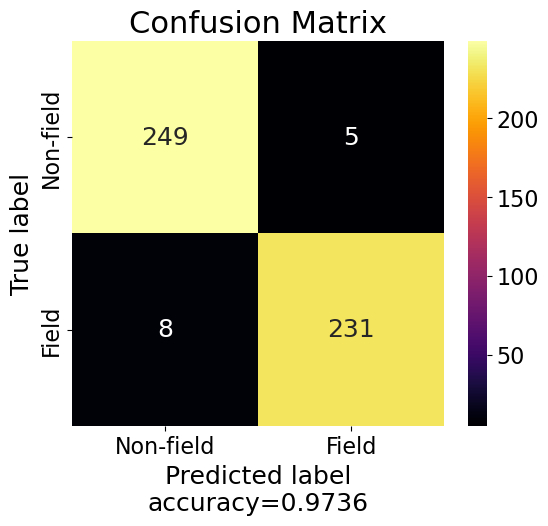

In [70]:
# Confusion matrix and class names
cm = np.array(conf_matrix_values)
class_names = ['Non-field', 'Field'] 

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='inferno',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.ylabel('True label')
plt.xlabel(f'Predicted label\naccuracy={overall_accuracy:.4f}')
plt.title('Confusion Matrix')

# Save Conf Matrix
plt.savefig('/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/exports/confusion_matrix_500_best_2.png', dpi=300, bbox_inches='tight')
plt.show()

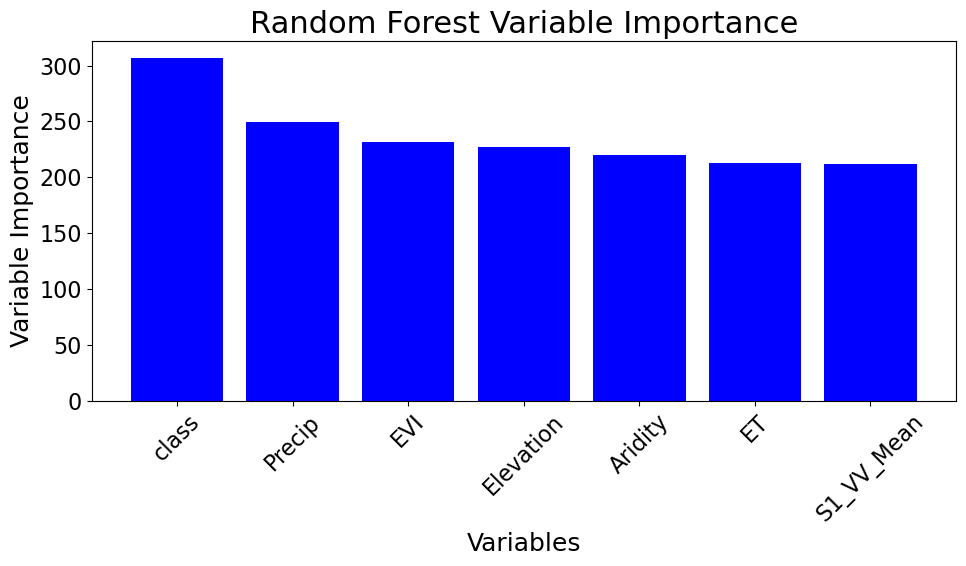

In [71]:
explanation = ee_classifier.explain()
importance = explanation.get('importance').getInfo()  # This is now a Python dict

# Sort by importance descending
sorted_items = sorted(importance.items(), key=lambda x: x[1], reverse=True)
variables, importances = zip(*sorted_items)

# Set font sizes globally for all elements
plt.rc('font', size=18)          # Default text size
plt.rc('axes', titlesize=22)     # Axes title font size
plt.rc('axes', labelsize=18)     # Axes labels font size
plt.rc('xtick', labelsize=16)    # X tick labels font size
plt.rc('ytick', labelsize=16)    # Y tick labels font size
plt.rc('legend', fontsize=16)    # Legend font size
plt.rc('figure', titlesize=24)   # Figure title font size

plt.figure(figsize=(10, 6))
plt.bar(variables, importances, color='blue')
plt.ylabel('Variable Importance')
plt.xlabel('Variables')
plt.title('Random Forest Variable Importance')
plt.xticks(rotation=45)
plt.tight_layout()

# Save Plot
plt.savefig('/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/exports/variable_importance_500_best_2.png', dpi=300, bbox_inches='tight')
plt.show()

In [58]:
# Export classifier as an asset (run once)
ee.batch.Export.classifier.toAsset(
    classifier=ee_classifier,
    description='ExportRFModel',
    assetId='projects/angola-thesis/assets/Predictions/crop_classifier_500_best_2'
).start()
print("Classifier export started. Wait for completion before predicting tiles.")

Classifier export started. Wait for completion before predicting tiles.


### Predict Test Tile with RF Model

In [51]:
classifier_asset = 'projects/angola-thesis/assets/Predictions/crop_classifier_500_best_2'
rf_classifier = ee.Classifier.load(classifier_asset)
tile_ids = [907535]

for tile_id in tile_ids:
    selected_tile = tiles.filter(ee.Filter.eq('tile', tile_id))
    prediction = full_stack_10m.select(important_bands) \
                              .updateMask(built_up_mask) \
                              .clip(selected_tile.geometry()) \
                              .reproject('EPSG:32733', scale=10) \
                              .classify(rf_classifier)
    # Export to EE Asset
    task_asset = ee.batch.Export.image.toAsset(
        image=prediction,
        description=f'Prediction_{tile_id}_Asset',
        assetId=f'projects/angola-thesis/assets/Predictions/tile_{tile_id}_500_1',
        region=selected_tile.geometry(),
        scale=10,
        crs='EPSG:32733',
        maxPixels=1e13
    )
    task_asset.start()
    print(f"Asset export started for tile {tile_id}.")

Asset export started for tile 907535.


#### Visualize Test Prediction

In [39]:
# Initialize the map
Map = geemap.Map()

# Loop over all tile IDs and add each as a layer
for tile_id in tile_ids:
    prediction_asset = f'projects/angola-thesis/assets/Predictions/tile_{tile_id}'
    prediction_img = ee.Image(prediction_asset)
    Map.addLayer(prediction_img, {'min': 0, 'max': 1, 'palette': ['red', 'green']}, f'Tile {tile_id}')

# Optionally center the map on the first tile
selected_tile = tiles.filter(ee.Filter.eq('tile', tile_ids[0]))
Map.centerObject(selected_tile.geometry(), 12)

#Display all predictor Variables
#for band in band_order:
    #Map.addLayer(full_stack_10m.select(band).mask(), {'min': 0, 'max': 1, 'palette': ['black', 'white']}, f'{band} mask')

Map

Map(center=[-15.284998419691945, 19.184000304984533], controls=(WidgetControl(options=['position', 'transparen…

#### Export Test Prediction from GEE to Drive

#### 1.) With Classification

In [88]:
classifier_asset = 'projects/angola-thesis/assets/Predictions/crop_classifier_500_best_2'
rf_classifier = ee.Classifier.load(classifier_asset)

no_data_val = -9999
tile_ids = [907535]

for tile_id in tile_ids:
    selected_tile = tiles.filter(ee.Filter.eq('tile', tile_id))
    # Recompute prediction for Drive export (critical!)
    prediction = full_stack_10m.select(important_bands) \
                              .updateMask(built_up_mask) \
                              .clip(selected_tile.geometry()) \
                              .reproject('EPSG:32733', scale=10) \
                              .classify(rf_classifier)
    prediction_unmasked = prediction.unmask(no_data_val).toFloat()
    
    # Export to Google Drive
    task_drive = ee.batch.Export.image.toDrive(
        image=prediction_unmasked,
        description=f'Prediction_{tile_id}_Drive',
        folder='GEE_Exports',
        fileNamePrefix=f'prediction_tile_{tile_id}_500_2',
        region=selected_tile.geometry(),
        scale=10,
        crs='EPSG:32733',
        maxPixels=1e13,
        fileFormat='GeoTIFF',
        formatOptions={'noData': no_data_val}
    )
    task_drive.start()
    print(f"Drive export started for tile {tile_id}.")

Drive export started for tile 907535.


#### 2.) With Probabilities and mask

In [253]:
rf_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=500,
    variablesPerSplit=3,
    minLeafPopulation=3,
    bagFraction=0.85,
    seed=42
).setOutputMode('MULTIPROBABILITY').train(
    features=training_data_full,
    classProperty='field',
    inputProperties=important_bands
)

no_data_val = -9999
tile_ids = [907535]

for tile_id in tile_ids:
    selected_tile = tiles.filter(ee.Filter.eq('tile', tile_id))
    
    # Get probabilities
    probabilities = full_stack_10m.select(important_bands) \
        .updateMask(mask) \
        .clip(selected_tile.geometry()) \
        .reproject('EPSG:32733', scale=10) \
        .classify(rf_classifier) \
        .arrayFlatten([['probability_0', 'probability_1']])

    # Apply threshold and unmask
    conservative_class = probabilities.select('probability_0') \
        .gt(0.85).Not().rename('conservative_class') \
        .unmask(no_data_val).toFloat()

    task_drive = ee.batch.Export.image.toDrive(
        image=conservative_class,
        description=f'ConservativePrediction_{tile_id}_Drive',
        folder='GEE_Exports',
        fileNamePrefix=f'tile_{tile_id}_prob_85',
        region=selected_tile.geometry(),
        scale=10,
        crs='EPSG:32733',
        maxPixels=1e13,
        fileFormat='GeoTIFF',
        formatOptions={'noData': no_data_val}
    )
    task_drive.start()
    print(f"Drive export started for tile {tile_id}.")

#### 3.) Only Probabilities

In [62]:
rf_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=500,
    variablesPerSplit=3,
    minLeafPopulation=3,
    bagFraction=0.85, 
    seed=42
).setOutputMode('MULTIPROBABILITY').train(
    features=training_data_full,
    classProperty='field',
    inputProperties=important_bands
)

no_data_val = -9999
tile_ids = [904714]

for tile_id in tile_ids:
    selected_tile = tiles.filter(ee.Filter.eq('tile', tile_id))
    
    # Get probabilities
    probabilities = full_stack_10m.select(important_bands) \
        .updateMask(mask) \
        .clip(selected_tile.geometry()) \
        .reproject('EPSG:32733', scale=10) \
        .classify(rf_classifier) \
        .arrayFlatten([['probability_0', 'probability_1']]) \
        .unmask(no_data_val).toFloat()  # Add unmasking here

    # Export PROBABILITIES instead of thresholded class
    task_drive = ee.batch.Export.image.toDrive(
        image=probabilities,
        description=f'ProbabilityExport_{tile_id}_Drive',
        folder='GEE_Exports',
        fileNamePrefix=f'tile_{tile_id}_probabilities',
        region=selected_tile.geometry(),
        scale=10,
        crs='EPSG:32733',
        maxPixels=1e13,
        fileFormat='GeoTIFF',
        formatOptions={'noData': no_data_val}
    )
    task_drive.start()
    print(f"Drive export started for tile {tile_id}.")

Drive export started for tile 904714.


### **Prediction on Entire Study Area**

In [89]:
# Load your study area geometry
study_area = ee.FeatureCollection('projects/angola-thesis/assets/angola_tiles_dissolve')

classifier_asset = 'projects/angola-thesis/assets/Predictions/crop_classifier_500_best_2'
rf_classifier = ee.Classifier.load(classifier_asset).setOutputMode('MULTIPROBABILITY')

no_data_val = -9999

# Apply the classifier to the entire region
full_prediction = full_stack_10m.select(important_bands) \
    .updateMask(mask) \
    .classify(rf_classifier) \
    .clip(study_area) \
    .reproject('EPSG:32733', scale=10) \
    .unmask(no_data_val, sameFootprint=False).toFloat()

#Export to Drive
task = ee.batch.Export.image.toDrive(
    image=full_prediction,
    description='Full_Study_Area_Prediction',
    folder='GEE_Exports',
    fileNamePrefix='study_area_pred_',
    region=study_area.geometry(),
    scale=10,
    crs='EPSG:32733',
    maxPixels=1e13,
    fileDimensions=[32768, 32768],
    skipEmptyTiles=True
)
task.start()
print("Full study area export started. Check tasks tab.")

Full study area export started. Check tasks tab.


#### 2.) With Probability Mask

In [63]:
# Train classifier in MULTIPROBABILITY mode (same as tile processing)
rf_classifier = ee.Classifier.smileRandomForest(
    numberOfTrees=500,
    variablesPerSplit=3,
    minLeafPopulation=3,
    bagFraction=0.85, 
    seed=42
).setOutputMode('MULTIPROBABILITY').train(
    features=training_data_full,
    classProperty='field',
    inputProperties=important_bands
)

# Load study area geometry
study_area = ee.FeatureCollection('projects/angola-thesis/assets/angola_tiles_dissolve')
no_data_val = -9999

# Process full study area with conservative threshold
probabilities_full = full_stack_10m.select(important_bands) \
    .updateMask(mask) \
    .classify(rf_classifier) \
    .arrayFlatten([['probability_0', 'probability_1']]) \
    .clip(study_area) \
    .reproject('EPSG:32733', scale=10)

# Apply conservative classification rule: 1=crop unless non-crop prob > 0.75
conservative_full = probabilities_full.select('probability_0') \
    .gt(0.75).Not().rename('conservative_class') \
    .unmask(no_data_val).toFloat()

# Export to Drive with tile handling
task = ee.batch.Export.image.toDrive(
    image=conservative_full,
    description='Full_Study_Area_Prob_75',
    folder='GEE_Exports',
    fileNamePrefix='study_area_pred_prob_75_02',
    region=study_area.geometry(),
    scale=10,
    crs='EPSG:32733',
    maxPixels=1e13,
    fileDimensions=[32768, 32768],
    skipEmptyTiles=True,
    fileFormat='GeoTIFF',
    formatOptions={'noData': no_data_val}
)

task.start()
print("Full study area export started with probability filtering. Check tasks tab.")


Full study area export started with probability filtering. Check tasks tab.


<br>

---

<br>

# Section 4: Postprocessing

#### Convert RF Prediction Raster to UINT8 and Apply Morphological Opening to Remove Speckles

In [16]:
def remove_small_patches(arr, max_patch_size=4, nodata=255):
    """Remove patches of 0 or 1 with size <= max_patch_size"""
    result = arr.copy()
    for val in [0, 1]:
        mask = (arr == val)
        labeled, num_features = label(mask, structure=np.ones((3,3)))
        for i in range(1, num_features + 1):
            patch = (labeled == i)
            patch_size = np.sum(patch)
            if patch_size <= max_patch_size:
                result[patch] = 1 - val
    return result

input_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/RF_Model/model_output/rf_full_prediction_prob_75_02.tif"
output_path = input_path.replace('.tif', '_despeckled.tif')

with rasterio.open(input_path) as src:
    nodata_value = src.nodata if src.nodata is not None else -9999.0
    profile = src.profile.copy()
    profile.update(driver='GTiff', dtype='uint8', compress='lzw', nodata=255,
                   tiled=True, blockxsize=256, blockysize=256)

    with rasterio.open(output_path, 'w', **profile) as dst:
        for ij, window in tqdm(list(dst.block_windows()), desc="Despeckling"):
            # Read with 1-pixel buffer
            buffered_window = Window(window.col_off-1, window.row_off-1,
                                    window.width+2, window.height+2).intersection(Window(0,0,src.width,src.height))
            
            data = src.read(1, window=buffered_window)
            data_uint8 = np.where((data == nodata_value) | np.isnan(data), 255, (data >= 0.5).astype('uint8'))
            
            # Process and write
            processed = remove_small_patches(data_uint8, max_patch_size=4)
            dst.write(processed[1:-1, 1:-1], 1, window=window)

print(f"✅ Cleaned raster saved to: {output_path}")

Despeckling: 100%|█████████████████████████████████████████████████████████████| 315216/315216 [45:12<00:00, 116.19it/s]

✅ Cleaned raster saved to: /home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/RF_Model/model_output/rf_full_prediction_prob_75_02_despeckled.tif


#### Setting Small Patches to nodata

In [19]:
input_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/RF_Model/model_output/rf_full_prediction_prob_75_02_despeckled.tif"
output_path = input_path.replace('.tif', '_patchfiltered.tif')

def process_chunk(chunk, max_patch_size=4, nodata=255):
    """Remove small patches from a chunk (0s and 1s)"""
    processed = chunk.copy()
    
    # Process 0 patches
    mask_0 = (chunk == 0)
    labeled_0, num_0 = label(mask_0, structure=np.ones((3,3)))
    sizes_0 = np.bincount(labeled_0.ravel())
    for label_id in range(1, num_0 + 1):
        if sizes_0[label_id] <= max_patch_size:
            processed[labeled_0 == label_id] = nodata
    
    # Process 1 patches
    mask_1 = (chunk == 1)
    labeled_1, num_1 = label(mask_1, structure=np.ones((3,3)))
    sizes_1 = np.bincount(labeled_1.ravel())
    for label_id in range(1, num_1 + 1):
        if sizes_1[label_id] <= max_patch_size:
            processed[labeled_1 == label_id] = nodata
    
    return processed

with rasterio.open(input_path) as src:
    profile = src.profile.copy()
    nodata = profile.get('nodata', 255)
    profile.update(dtype='uint8', compress='lzw', tiled=True, blockxsize=256, blockysize=256)

    with rasterio.open(output_path, 'w', **profile) as dst:
        for ij, window in tqdm(list(dst.block_windows()), desc="Filtering patches"):
            # Read with 2-pixel buffer for edge handling
            buffered_window = Window(
                window.col_off - 2,
                window.row_off - 2,
                window.width + 4,
                window.height + 4
            ).intersection(Window(0, 0, src.width, src.height))
            
            data = src.read(1, window=buffered_window)
            data_uint8 = np.where((data == nodata) | np.isnan(data), nodata, (data >= 0.5).astype('uint8'))
            
            # Process chunk
            processed = process_chunk(data_uint8)
            
            # Write only the original window (trim buffer)
            dst.write(processed[2:-2, 2:-2], 1, window=window)

print(f"✅ Filtered raster saved to: {output_path}")

Filtering patches: 100%|███████████████████████████████████████████████████████| 315216/315216 [11:56<00:00, 440.17it/s]

✅ Filtered raster saved to: /home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/RF_Model/model_output/rf_full_prediction_prob_75_02_despeckled_patchfiltered.tif


### Mask Fractional Prediction Map

In [ ]:
# Input/output paths
buffered_mask_path = "/home/airg/PSteinhilber/projects/angola/prediction/FP_Analysis_Raster/RF_Model/model_output/buffered_mask_reprojected.tif"
fractional_map_path = "/home/airg/PSteinhilber/projects/angola/prediction/merged_fractional_map_final.tif"

# Get target CRS from fractional map
with rasterio.open(fractional_map_path) as frac_src:
    dst_crs = frac_src.crs
    dst_transform = frac_src.transform
    dst_width = frac_src.width
    dst_height = frac_src.height

# ====== STEP 1: REPROJECT RF PREDICTION TO TARGET CRS ======
reprojected_rf_path = rf_raster_path.replace('.tif', '_reprojected.tif')

with rasterio.open(rf_raster_path) as src:
    # Calculate transform for target CRS
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    
    # Create reprojected RF prediction
    profile = src.profile.copy()
    profile.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'dtype': 'uint8',
        'nodata': 0
    })
    
    with rasterio.open(reprojected_rf_path, 'w', **profile) as dst:
        for ij, window in tqdm(dst.block_windows(), desc="Reprojecting RF"):
            src_window = Window(
                window.col_off - 512, window.row_off - 512,
                window.width + 1024, window.height + 1024
            ).intersection(Window(0, 0, src.width, src.height))
            
            src_data = src.read(1, window=src_window)
            dst_data = np.zeros((window.height, window.width), dtype='uint8')
            
            reproject(
                source=src_data,
                destination=dst_data,
                src_transform=src.window_transform(src_window),
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )
            
            dst.write(dst_data, 1, window=window)

In [ ]:
# ====== STEP 2: BUFFER IN TARGET CRS ======
buffer_pixels = 3  # 30m buffer for 10m pixels
struct = np.ones((3,3), dtype=bool)

with rasterio.open(reprojected_rf_path) as src:
    profile = src.profile.copy()
    profile.update(dtype='uint8', nodata=0)
    
    with rasterio.open(buffered_mask_path, 'w', **profile) as dst:
        for ij, window in tqdm(dst.block_windows(), desc="Buffering"):
            # Read with buffer margin
            buffered_window = Window(
                window.col_off - buffer_pixels,
                window.row_off - buffer_pixels,
                window.width + 2*buffer_pixels,
                window.height + 2*buffer_pixels
            ).intersection(Window(0, 0, src.width, src.height))
            
            data = src.read(1, window=buffered_window)
            crop_mask = (data == 1).astype(bool)
            
            if np.any(crop_mask):
                for _ in range(buffer_pixels):
                    crop_mask = binary_dilation(crop_mask, structure=struct)
                
                # Trim to original window
                result = crop_mask[
                    buffer_pixels:-buffer_pixels,
                    buffer_pixels:-buffer_pixels
                ]
            else:
                result = np.zeros((window.height, window.width), dtype=bool)
            
            dst.write(result.astype('uint8'), 1, window=window)

# ====== STEP 3: APPLY MASK (NOW ALREADY ALIGNED) ======
with rasterio.open(buffered_mask_path) as mask_src, rasterio.open(fractional_map_path) as frac_src:
    profile = frac_src.profile.copy()
    profile.update(compress='lzw', nodata=frac_src.nodata)
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        for window in tqdm(frac_src.block_windows(), desc="Applying mask"):
            mask_data = mask_src.read(1, window=window).astype(bool)
            frac_data = frac_src.read(1, window=window)
            masked = np.where(mask_data, frac_data, profile['nodata'])
            dst.write(masked, 1, window=window)

print(f"✅ Final output saved to: {output_path}")